In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
import os
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import pymaster as nmt
import numpy as np

In [4]:
from cibinfo import fields

# Load data

## Generate fields

In [5]:
nside = 1024
npix = hp.nside2npix(nside)
lmax = 2048

# fwhm = 10./60.
# pixfunc = hp.pixwin(nside)[:lmax]
# beamfunc = hp.gauss_beam(fwhm=np.radians(fwhm), lmax=lmax-1)
# windowfunc = pixfunc * beamfunc

We generate a joint realization of the CIB and CMB lensing convergence. Here, map $X$ corresponds to the CIB, $Y$ corresponds to $\kappa$.

In [24]:
sim = fields.CIBxKappa(
    545, unit='MJy^2/sr',
    nside=nside,
    pixwin_cib=False,
    add_cib_noise=False, add_lensing_noise=True,
)

In [25]:
sim.generate()

/Users/dlenz/anaconda/lib/python3.6/site-packages/healpy/sphtfunc.py:295: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(array([-0.02333606, -0.06162238, -0.06965082, ..., -0.04078931,
        -0.01127027,  0.02874519]),
 array([ 0.48251589, -0.84310038, -0.60120698, ...,  1.01174682,
        -1.18911929,  0.47651514]))

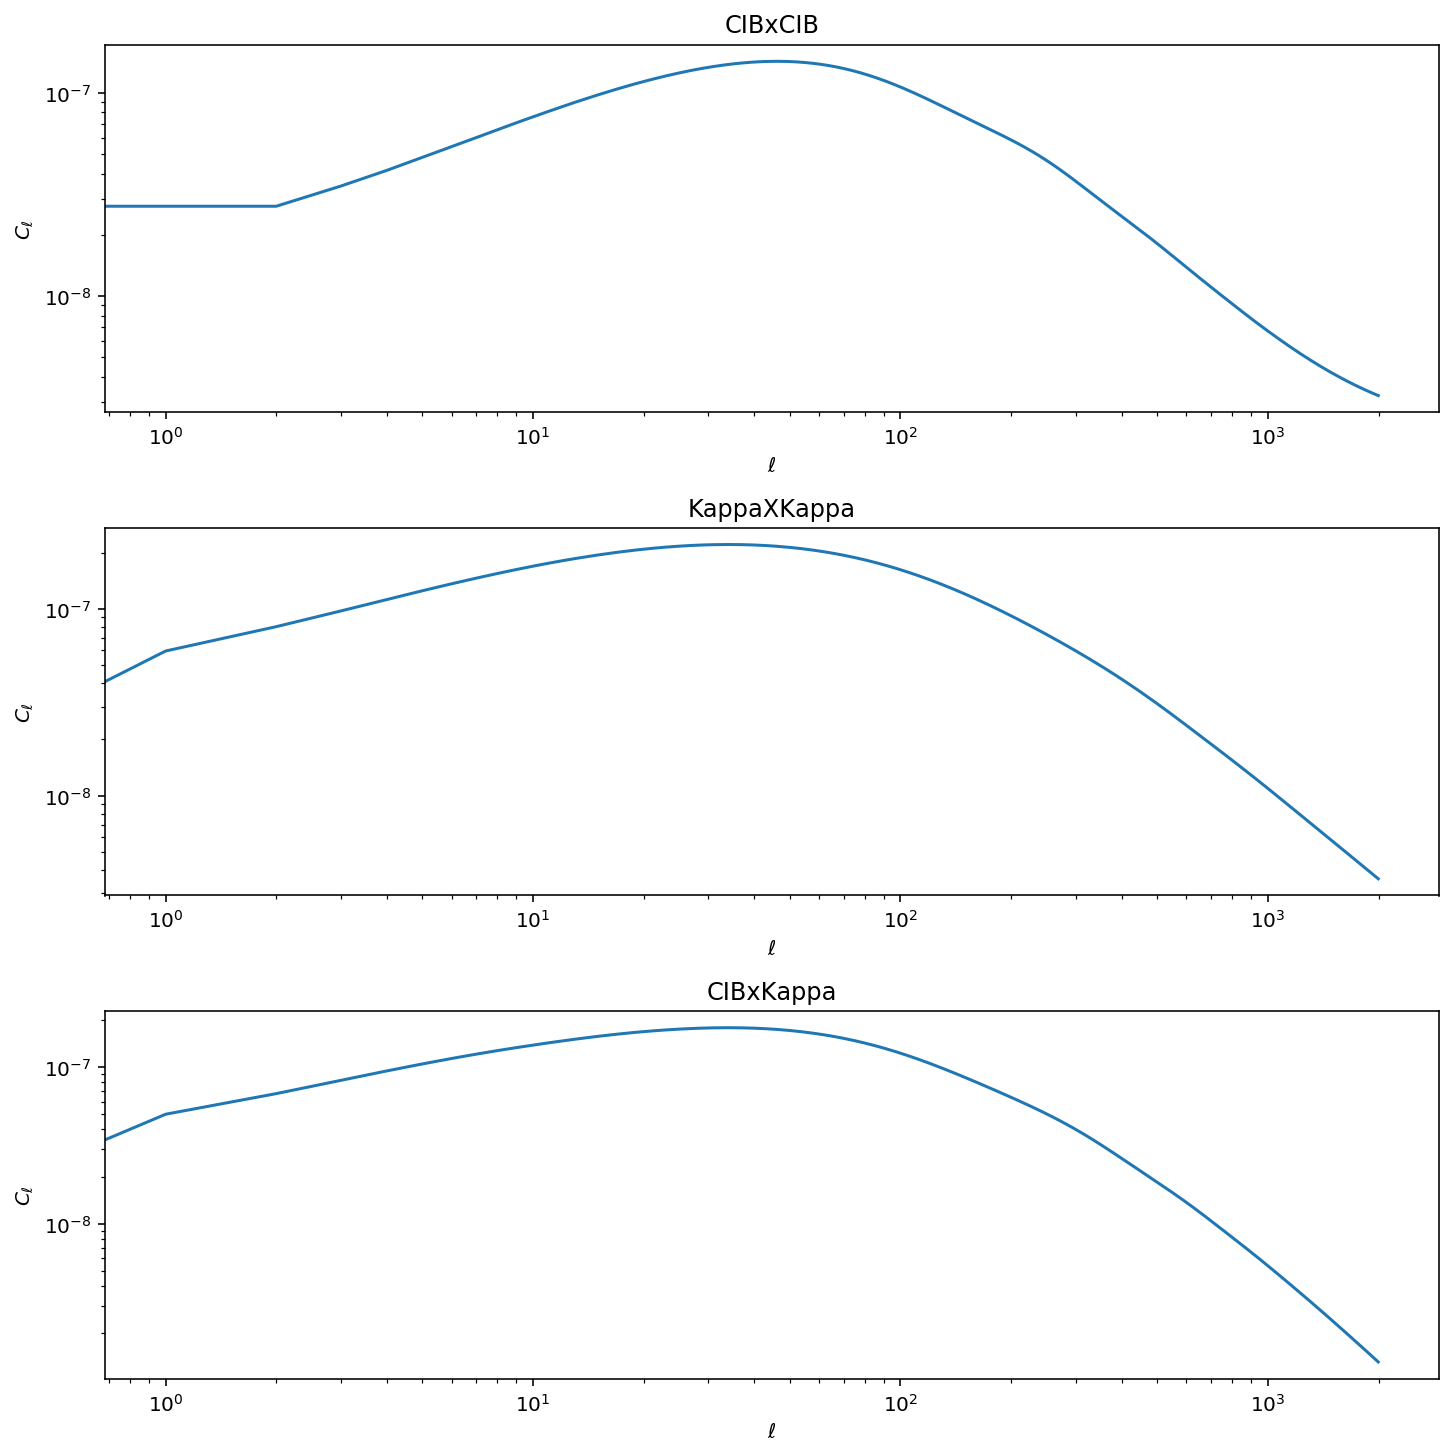

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10))

ax1.set_title('CIBxCIB')
ax1.loglog(
    sim.Cl_XX,
)

ax2.set_title('KappaXKappa')
ax2.loglog(
    sim.Cl_YY,
)

ax3.set_title('CIBxKappa')
ax3.loglog(
    sim.Cl_XY,
)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_{\ell}$')

Note that we added noise to the lensing realization, with values corresponding to the public _Planck_ results

Text(0,0.5,'$C_{\\ell}$')

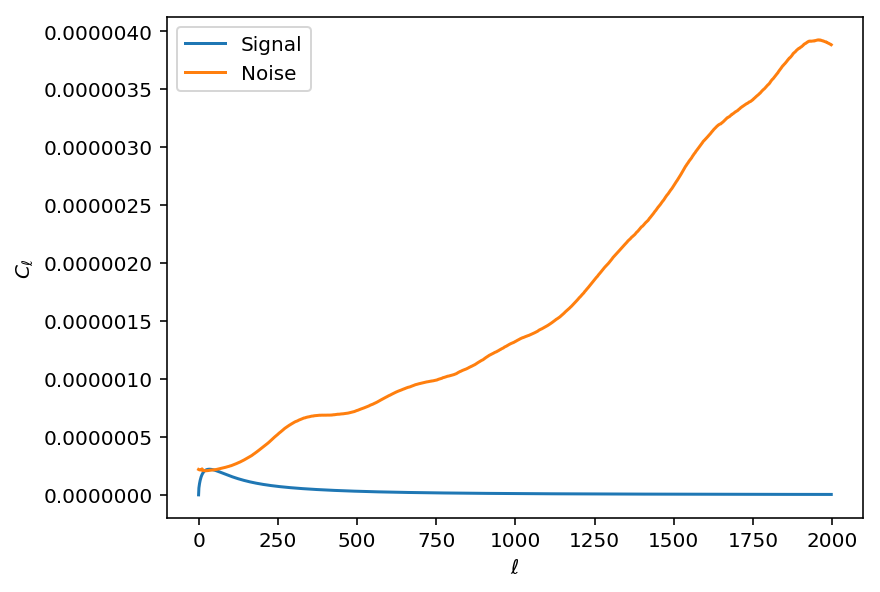

In [41]:
plt.plot(sim.Cl_YY, label='Signal')
plt.plot(sim.Nl_YY, label='Noise')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 

/Users/dlenz/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "



-> fwhm is 0.000000 arcmin


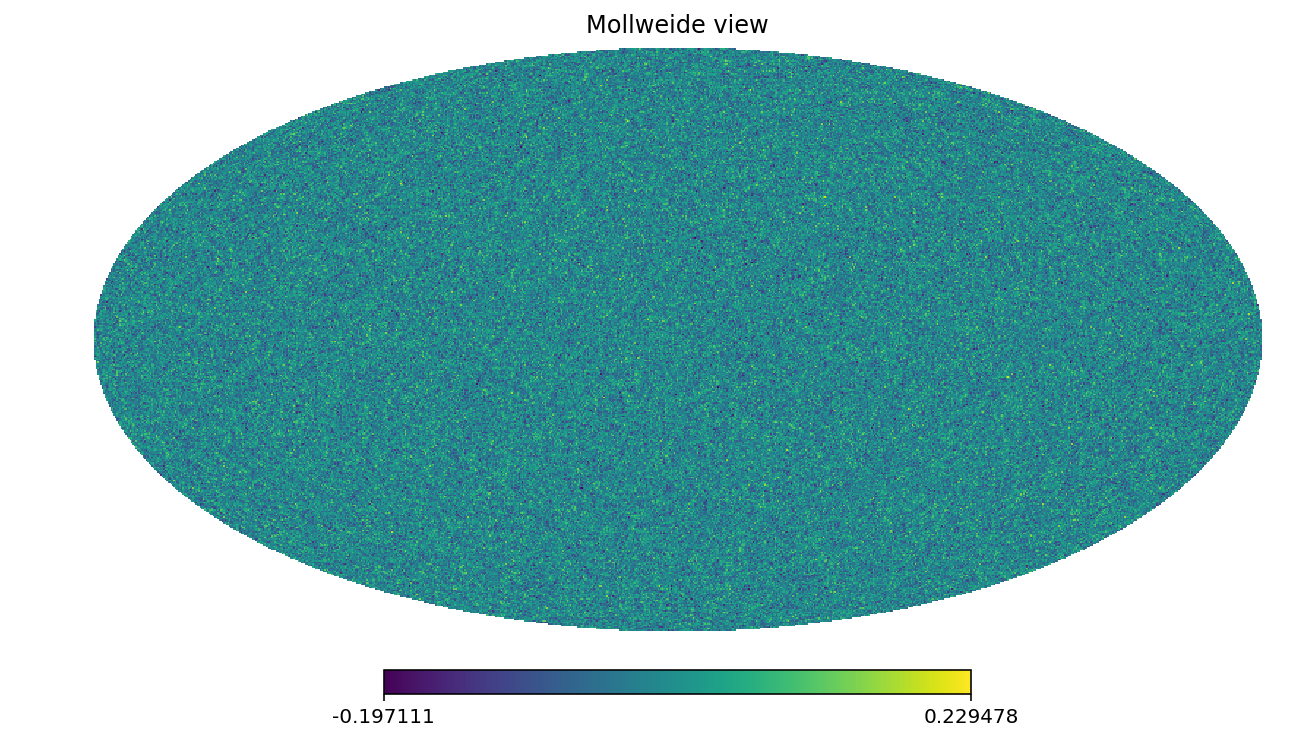

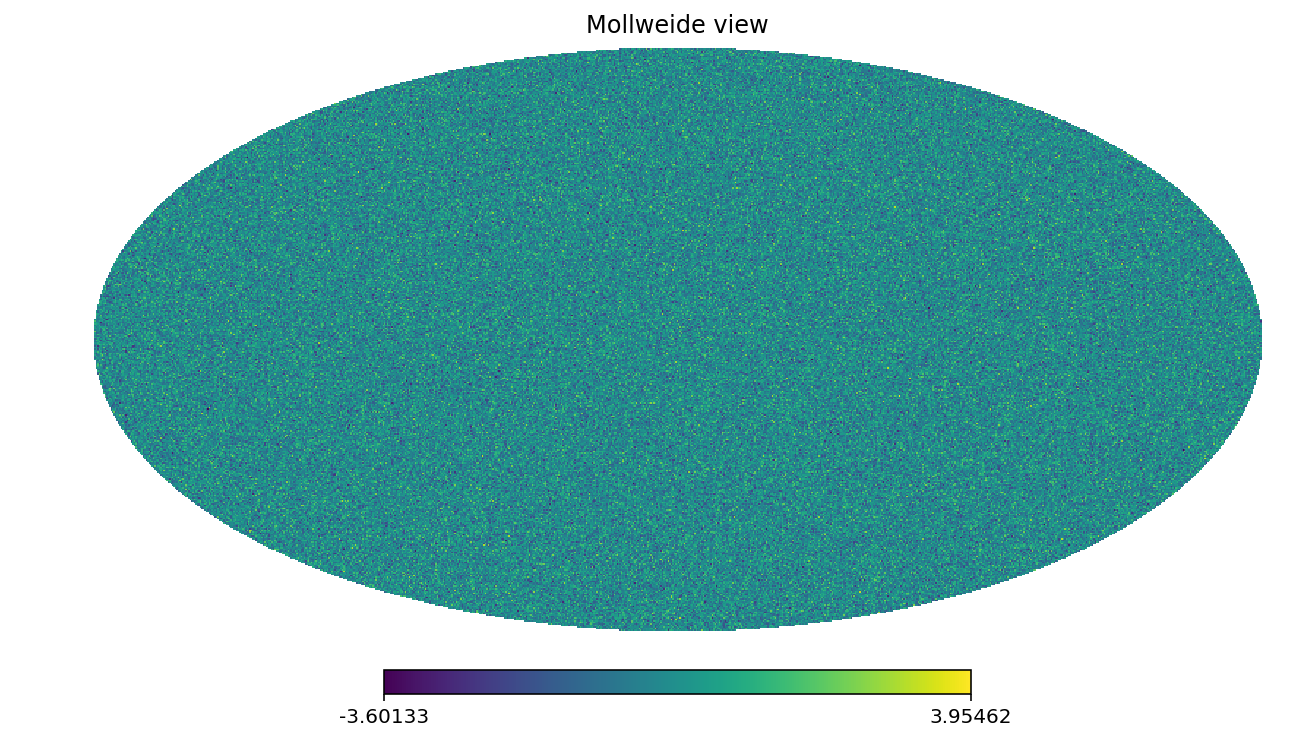

In [42]:
hp.mollview(sim.hpxmap_X)
hp.mollview(sim.hpxmap_Y)

## Load mask

In [16]:
mask = hp.read_map(
    '/home/jovyan/data/planck/raw/masks/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits',
    verbose=False,
)

mask = hp.ud_grade(mask, nside)

In [18]:
fsky = mask.sum()/mask.size
fsky

0.7803804675738016

/Users/dlenz/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


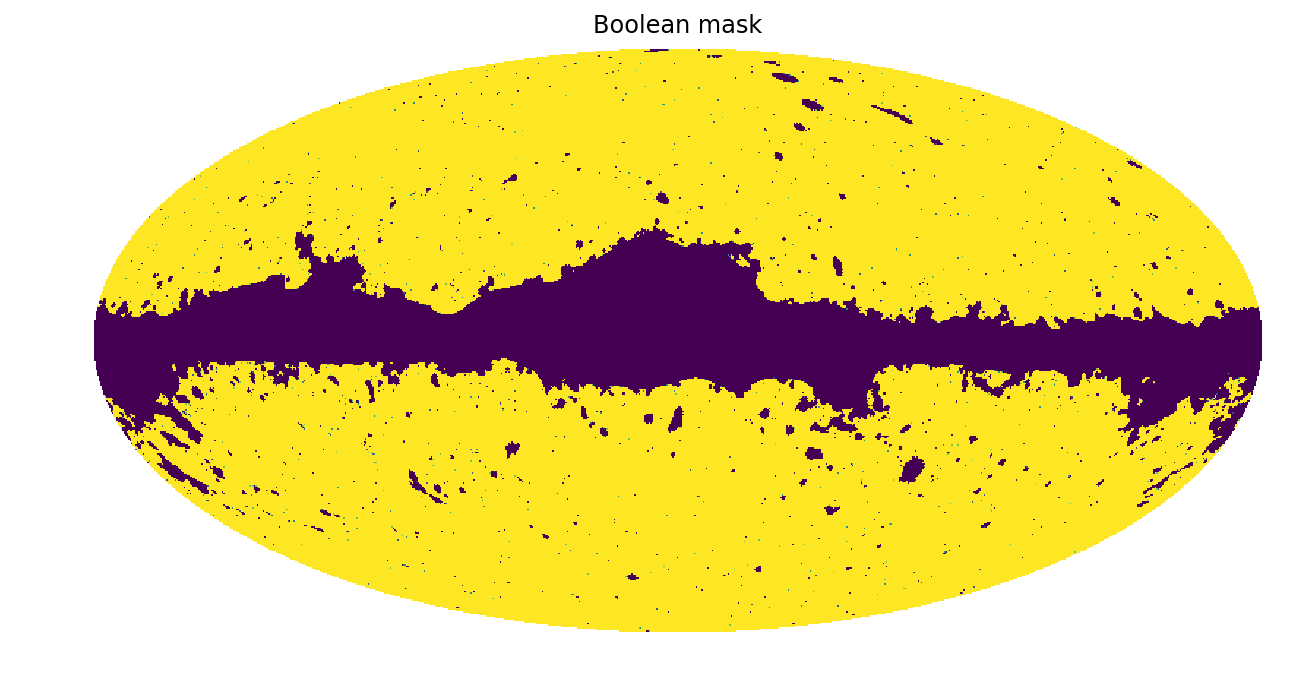

In [22]:
hp.mollview(mask, title='Boolean mask', cbar=0)

# Reconstruct power spectra

In [23]:
lmax = 1500

## `hp.anafast()`

In [28]:
ell_anafast = np.arange(lmax)

In [31]:
Cl_anafast = hp.anafast(
    map1=sim.hpxmap_X*mask,
    map2=sim.hpxmap_Y*mask,
    lmax=lmax-1,
)

Cl_anafast /= fsky

In [43]:
field1 = nmt.NmtField(
    mask=mask,
    maps=[sim.hpxmap_X, ],
)

field2 = nmt.NmtField(
    mask=mask,
    maps=[sim.hpxmap_Y, ],
)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [72]:
nlb = 32
b = nmt.NmtBin(
    nside=nside,
    nlb=nlb,
    lmax=lmax,
)

In [61]:
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field1, field2, b)

In [62]:
ell_nmt = b.get_effective_ells()
Cl_nmt = nmt.compute_full_master(field1, field2, b, workspace=wsp).squeeze()

## Plot results (w/o errors for now)

(1e-06, 2e-05)

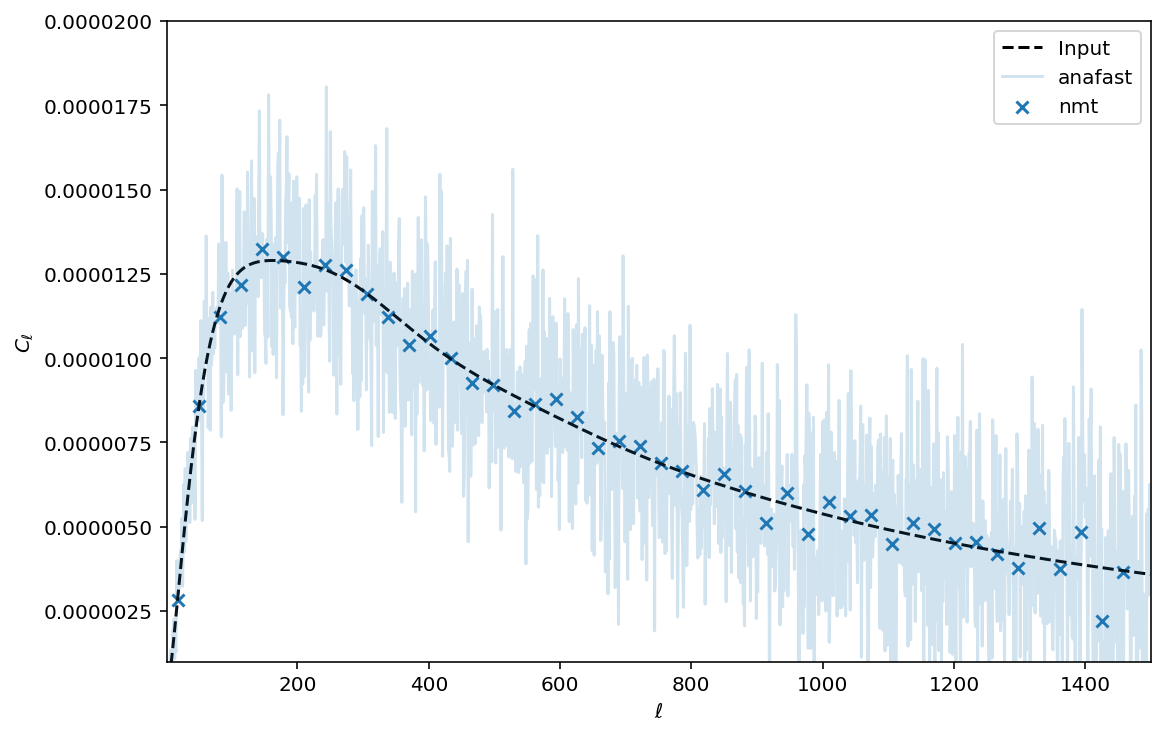

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

# Input
p = ax.plot(
    ell_anafast,
    ell_anafast*sim.Cl_XY[:lmax],
    c='k', ls='--',
    label='Input',
)

# anafast
ax.plot(
    ell_anafast,
    ell_anafast*Cl_anafast,
    alpha=0.2,
    label='anafast',
)

# NaMaster
ax.scatter(
    ell_nmt,
    ell_nmt*Cl_nmt,
    marker='x',
    label='nmt',
)

# for cap in caps:
#     cap.set_color('k')
#     cap.set_markeredgewidth(1)

# ax.semilogy();

# Legend
ax.legend()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_{\ell}$')

# Limits
ax.set_xlim(1, lmax)
ax.set_ylim(1.e-6, 2.e-5)

# Estimate errors

## Binned anafast

In [97]:
ell_anafast_b = np.mean(ell_anafast.reshape((-1, 30)), 1)
Cl_anafast_b = np.mean((ell_anafast*Cl_anafast).reshape((-1, 30)), 1)/ell_anafast_b
dCl_anafast_b = np.std((ell_anafast*Cl_anafast).reshape((-1, 30)), 1)/ell_anafast_b

## Analytical

In [54]:
def get_Nl_analytical(b, Cl_xx, Cl_yy, Cl_xy, Nl_xx, Nl_yy, nlb, fsky=1.):
    """Compute the analytical error on a cross power spectrum in the presence of noise
    in both components.
    """
    ell_scaling = np.sqrt(1./(fsky*(2*b+1) * nlb))
    
    error = Cl_xx * Cl_yy
    error += Cl_xy**2
    error += Cl_yy * Nl_xx
    error += Cl_xx * Nl_yy
    error += Nl_xx * Nl_yy

    error_eff = np.sqrt(error) * ell_scaling
    error_eff = error_eff.squeeze()
    
    return error_eff

In [73]:
Nl_analytical = get_Nl_analytical(
    b=ell_nmt,
    Cl_xx=wsp.decouple_cell(wsp.couple_cell([sim.Cl_XX[:lmax+1], ])).squeeze(),
    Cl_yy=wsp.decouple_cell(wsp.couple_cell([sim.Cl_YY[:lmax+1], ])).squeeze(),
    Cl_xy=wsp.decouple_cell(wsp.couple_cell([sim.Cl_XY[:lmax+1], ])).squeeze(),
    Nl_xx=np.zeros_like(ell_nmt),
    Nl_yy=wsp.decouple_cell(wsp.couple_cell([sim.Nl_YY[:lmax+1], ])).squeeze(),
    fsky=fsky,
    nlb=nlb,
    )

## nmt covariance

In [99]:
def adjust_nmt_Cl_length(Cl, nside=None, lmax=None):
    """Pymaster requires the Cls to have a length of exactly
    3 * nside. This function returns a set of Cl that is either cut
    or extended to fit this need.

    If the input Cl is too long, it is simply truncated.

    If the input Cl is too short, then the last element is
    simply repeated until the length is 3*nside.

    :param Cl: Input Cl
    :param nside: Valid HEALPix nside
    """

    if lmax is None:
        lmax = 3 * nside
    # > 0 if too short, < 0 if too long
    len_diff = lmax - Cl.shape[0]

    # Just return for perfect match
    if len_diff == 0:
        return Cl
    
    # Extend if too short
    if len_diff > 0:
        Cl = np.concatenate((
            Cl, np.repeat(Cl[-1], repeats=len_diff)
            ))
        
    # Cut if too long
    else:
        Cl = Cl[:lmax]
    
    return Cl

In [100]:
def get_nmt_covar(wsp, cl_theo1, cl_theo2=None):
    
    if cl_theo2 is None:
        cl_theo2 = cl_theo1.copy()

    wsp_covar = nmt.NmtCovarianceWorkspace()

    wsp_covar.compute_coupling_coefficients(wsp, wsp)

    lmax = wsp_covar.wsp.lmax_a + 1
    
    cl_theo1 = adjust_nmt_Cl_length(cl_theo1, lmax=lmax)
    cl_theo2 = adjust_nmt_Cl_length(cl_theo2, lmax=lmax)
    
    covar = nmt.gaussian_covariance(
        wsp_covar,
        cl_theo1, cl_theo2,
        cl_theo1, cl_theo2)

    return covar

In [101]:
covar = get_nmt_covar(
    wsp,
    cl_theo1=sim.Cl_XX,
    cl_theo2=sim.Cl_YY+sim.Nl_YY)

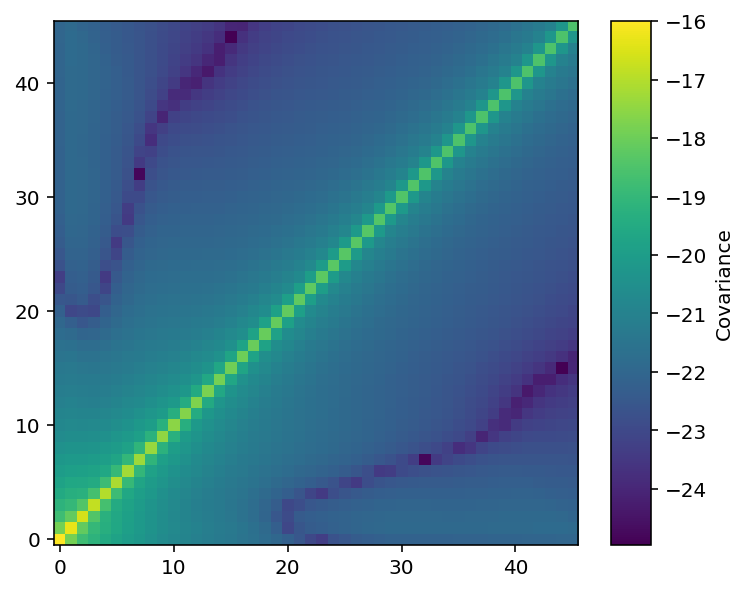

In [102]:
im = plt.imshow(np.log10(np.abs(covar)), origin='lower', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.set_label('Covariance')

In [103]:
Nl_covar = np.sqrt(np.diag(covar))

## Re-do plot with errors

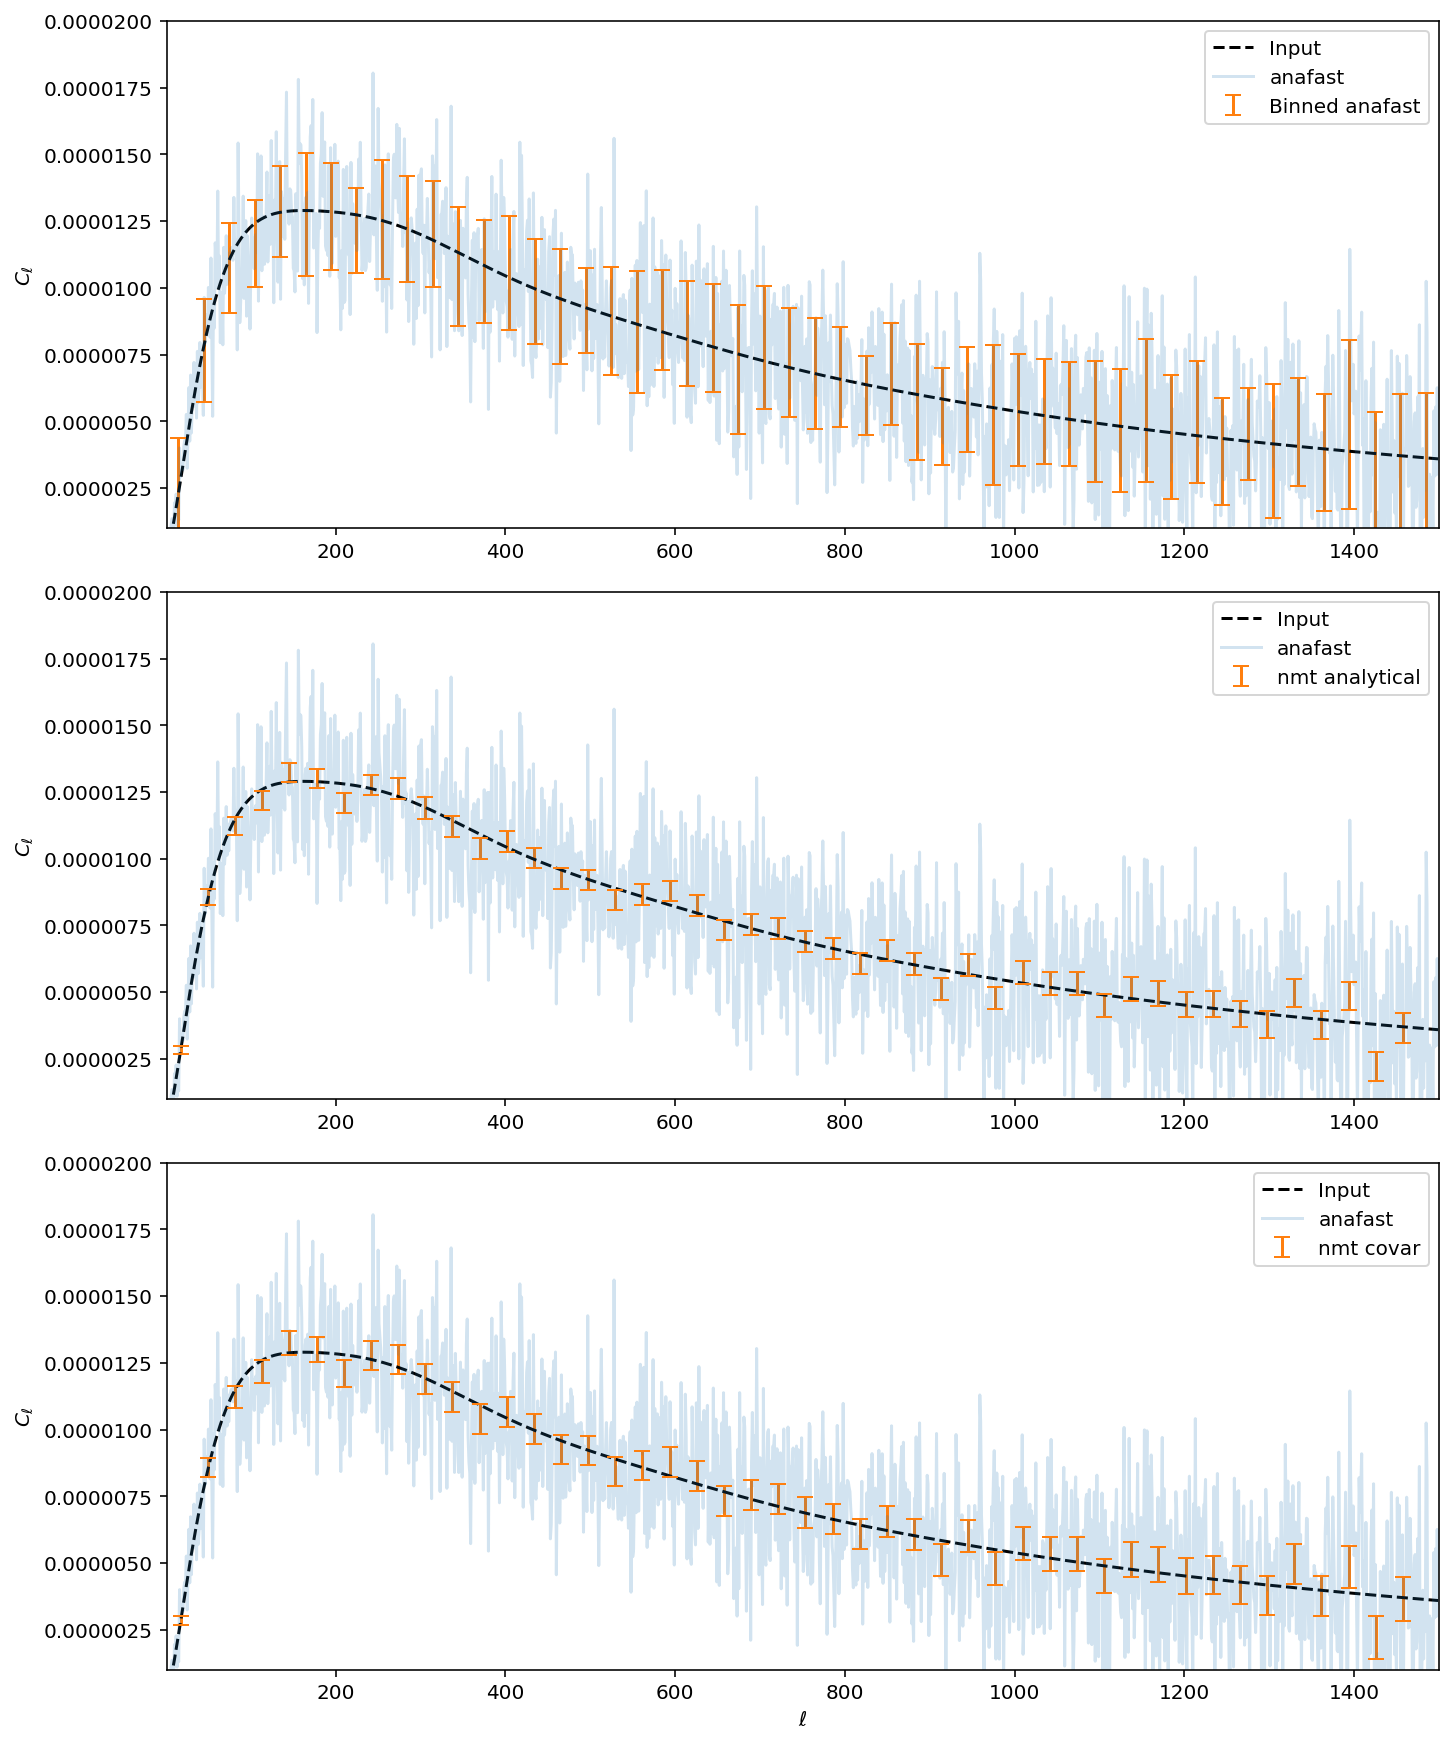

In [104]:
fig, axes = plt.subplots(figsize=(10, 12), nrows=3)
ax1, ax2, ax3 = axes

# Input
for ax in axes:
    ax.plot(
        ell_anafast,
        ell_anafast*sim.Cl_XY[:lmax],
        c='k', ls='--',
        label='Input',
    )

# anafast
for ax in axes:
    p = ax.plot(
        ell_anafast,
        ell_anafast*Cl_anafast,
        alpha=0.2,
        label='anafast',
    )

# Binned anafast
ax1.errorbar(
    ell_anafast_b,
    ell_anafast_b*Cl_anafast_b,
    yerr=ell_anafast_b*dCl_anafast_b,
    marker='', linestyle='None',
    label='Binned anafast', capsize=4,
)
    
# NaMaster w/ analytical errors
ax2.errorbar(
    ell_nmt,
    ell_nmt*Cl_nmt,
    yerr=ell_nmt*Nl_analytical,
    marker='', linestyle='None',
    label='nmt analytical', capsize=4,
)

# NaMaster w/ errors from diagonal of covariance
ax3.errorbar(
    ell_nmt,
    ell_nmt*Cl_nmt,
    yerr=ell_nmt*Nl_covar,
    marker='', linestyle='None',
    label='nmt covar', capsize=4,
)

# Legend
for ax in axes:
    ax.legend()
    ax.set_ylabel(r'$C_{\ell}$')
    
ax3.set_xlabel(r'$\ell$')

# Limits
for ax in axes:
    ax.set_xlim(1, lmax)
    ax.set_ylim(1.e-6, 2.e-5)